<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [20]:
import os
import glob
import random
import json
import warnings
from collections import defaultdict
from monai.transforms import (EnsureChannelFirstd, Compose, LoadImaged, Spacingd, Resized)
from monai.data import CacheDataset, DataLoader
import os
import random
from collections import defaultdict
from monai.data import Dataset
from monai.utils import first, set_determinism
import matplotlib.pyplot as plt
import torch
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd


In [3]:
root_dir ="C:/Users/zshah/Downloads/ASC-PET-TEST"

## Set dataset path

In [4]:

train_images = sorted(glob.glob(os.path.join(root_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(root_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]

# making  smaller input to save time for practing stage:
# train_files, val_files =  data_dicts[:20], data_dicts[-5:]
train_files, val_files =  data_dicts[:], data_dicts[:]




In [5]:
from monai.transforms import LoadImage

# Function to load an image and print its size
def print_image_size(file_info):
    loader = LoadImage(image_only=True)
    image = loader(file_info['image'])
    print(f"Image size: {image.shape}")

# Print sizes of the last few images in the train_files
print("Train Files:")
for file_info in train_files:  # Adjust the number as needed
    print_image_size(file_info)

# Print sizes of the last few images in the val_files
print("\nValidation Files:")
for file_info in val_files:  # Adjust the number as needed
    print_image_size(file_info)



Train Files:
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([192, 192, 345])
Image size: torch.Size([200, 200, 317])
Image size: torch.Size([168, 168, 323])
Image size: torch.Size([180, 180, 317])

Validation Files:
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([192, 192, 345])
Image size: torch.Size([200, 200, 317])
Image size: torch.Size([168, 168, 323])
Image size: torch.Size([180, 180, 317])


In [36]:
def print_image_info(file_info, transforms):
    loader = LoadImage(image_only=True)
    image = loader(file_info['image'])
    print(f"Original image size: {image.shape}")
    
    # Apply transformations
    transformed_image = transforms(file_info)
    print(f"Transformed image size: {transformed_image['image'].shape}")

# Define your transforms
train_transforms = Compose([
    LoadImaged(keys=["image", "target"]),
    EnsureChannelFirstd(keys=["image", "target"]),
    Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
    SpatialPadd(keys=["image", "target"], spatial_size=[96, 96, 96], mode='constant', method='symmetric'),
])

# # Example usage
# print("Train Files:")
# for file_info in train_files[-5:]:  # Adjust the number as needed
#     print_image_info(file_info, train_transforms)

print("\nValidation Files:")
for file_info in val_files[-5:]:  # Adjust the number as needed
    print_image_info(file_info, train_transforms)


C:\Users\zshah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


Train Files:
Original image size: torch.Size([168, 168, 318])
Transformed image size: torch.Size([1, 454, 454, 476])
Original image size: torch.Size([192, 192, 345])
Transformed image size: torch.Size([1, 465, 465, 562])
Original image size: torch.Size([200, 200, 317])
Transformed image size: torch.Size([1, 541, 541, 475])
Original image size: torch.Size([168, 168, 323])
Transformed image size: torch.Size([1, 454, 454, 484])
Original image size: torch.Size([180, 180, 317])
Transformed image size: torch.Size([1, 492, 492, 475])

Validation Files:
Original image size: torch.Size([168, 168, 318])
Transformed image size: torch.Size([1, 454, 454, 476])
Original image size: torch.Size([192, 192, 345])
Transformed image size: torch.Size([1, 465, 465, 562])
Original image size: torch.Size([200, 200, 317])
Transformed image size: torch.Size([1, 541, 541, 475])
Original image size: torch.Size([168, 168, 323])
Transformed image size: torch.Size([1, 454, 454, 484])
Original image size: torch.Size(

In [38]:
def get_voxel_spacing(file_path):
    loader = LoadImage(image_only=False)  # Load image and metadata
    _, meta_data = loader(file_path)
    print(meta_data.keys())  # Print all metadata keys to identify the correct one for spacing
    spacing = meta_data.get('spacing', None)  # Use .get() to avoid KeyError if 'spacing' is not present
    if spacing is None:
        print(f"No spacing information found in metadata for file: {file_path}")
    return spacing

# Test the function with one image to inspect the metadata keys
get_voxel_spacing(data_files[0])


dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj'])
No spacing information found in metadata for file: C:/Users/zshah/Downloads/ASC-PET-TEST\NAC\001801_C1_RZ_Re7_.nii.gz


In [39]:
def get_voxel_spacing(file_path):
    loader = LoadImage(image_only=False)  # Load image and metadata
    _, meta_data = loader(file_path)
    # The first element of 'pixdim' is often 1 and not used for spacing,
    # so we take the next three elements which represent the voxel spacings in X, Y, and Z.
    spacing = meta_data['pixdim'][1:4]  # Extract voxel spacing from 'pixdim'
    return spacing

# Now, let's gather voxel spacings for all images again with the corrected approach
voxel_spacings = np.array([get_voxel_spacing(file_path) for file_path in data_files])

# Continue with the histogram and mode calculation as before


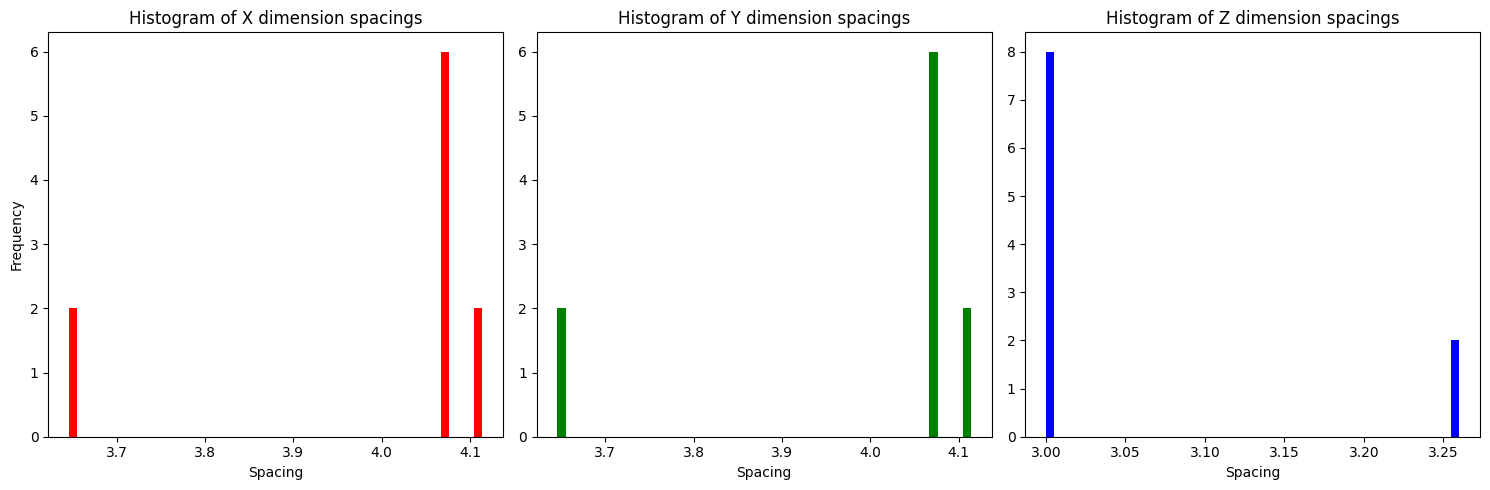

In [40]:
# Assuming voxel_spacings is an Nx3 array where N is the number of images, and each row is the spacing (x, y, z)
plt.figure(figsize=(15, 5))

# X dimension spacings
plt.subplot(1, 3, 1)
plt.hist(voxel_spacings[:, 0], bins=50, color='r')
plt.title('Histogram of X dimension spacings')
plt.xlabel('Spacing')
plt.ylabel('Frequency')

# Y dimension spacings
plt.subplot(1, 3, 2)
plt.hist(voxel_spacings[:, 1], bins=50, color='g')
plt.title('Histogram of Y dimension spacings')
plt.xlabel('Spacing')

# Z dimension spacings
plt.subplot(1, 3, 3)
plt.hist(voxel_spacings[:, 2], bins=50, color='b')
plt.title('Histogram of Z dimension spacings')
plt.xlabel('Spacing')

plt.tight_layout()
plt.show()


In [6]:

# Assuming the desired input size for the model is [96, 96, 96]
desired_size = [96, 96, 96]

train_transforms = Compose([
    LoadImaged(keys=["image", "target"]),
    EnsureChannelFirstd(keys=["image", "target"]),
    Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
    SpatialPadd(keys=["image", "target"], spatial_size=desired_size, mode='constant', method='symmetric'),
    # Additional transforms can be added here
])

val_transforms = Compose([
    LoadImaged(keys=["image", "target"]),
    EnsureChannelFirstd(keys=["image", "target"]),
    Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
    SpatialPadd(keys=["image", "target"], spatial_size=desired_size, mode='constant', method='symmetric'),
    # Additional transforms can be added here
])


train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



Loading dataset: 100%|██████████| 5/5 [01:54<00:00, 22.98s/it]


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


image shape: torch.Size([454, 454, 476]), target shape: torch.Size([454, 454, 476])


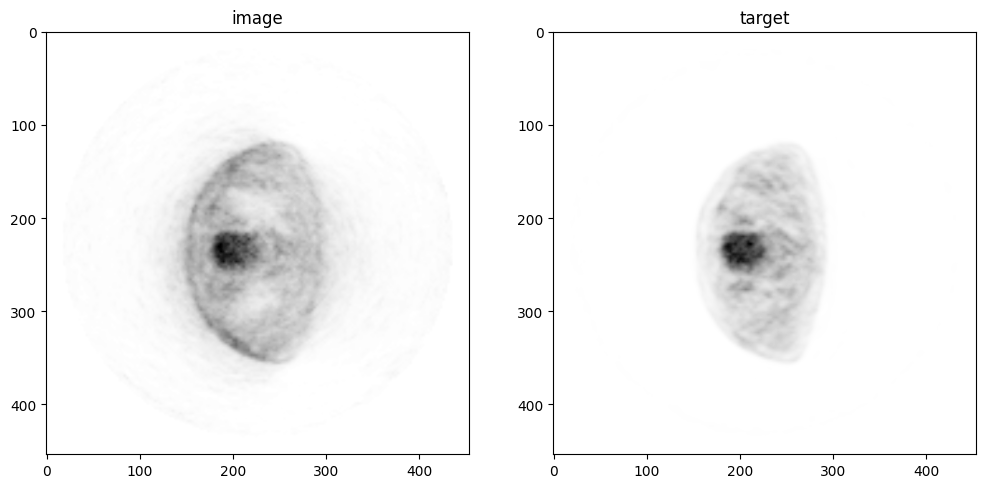

In [34]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 100



plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='gist_yarg' )
plt.show()

In [24]:

import numpy as np

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")


image shape: torch.Size([454, 454, 476]), target shape: torch.Size([454, 454, 476])


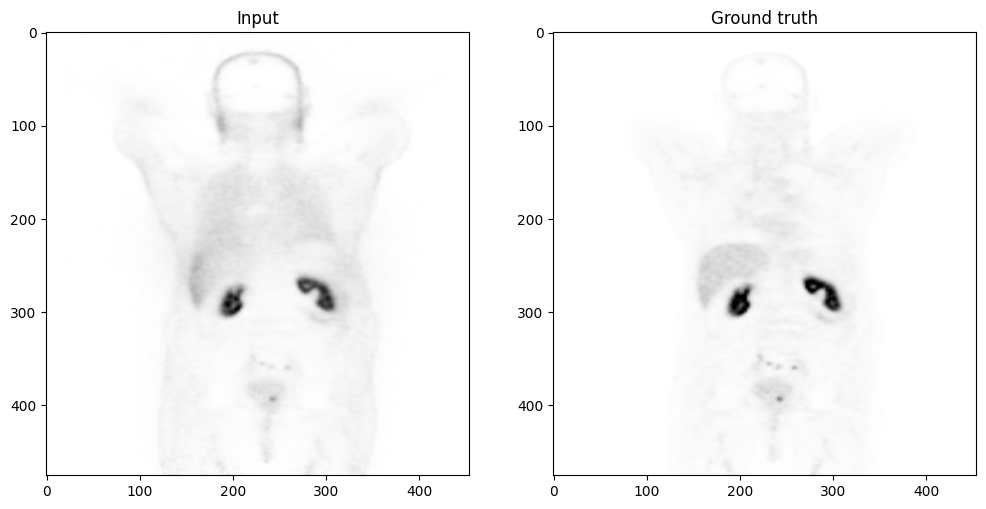

In [32]:

n = 220  # Selecting the slice

plt.figure(figsize=(12, 6))  # Correct way to set figure size
plt.subplot(1, 2, 1)
plt.title("Input")
# Rotate the slice and plot
input_slice = np.rot90(image[:, n, :])
plt.imshow(input_slice, cmap="gist_yarg")

plt.subplot(1, 2, 2)
plt.title("Ground truth")
# Rotate the slice and plot
target_slice = np.rot90(target[:, n, :])
plt.imshow(target_slice, cmap='gist_yarg')

plt.show()


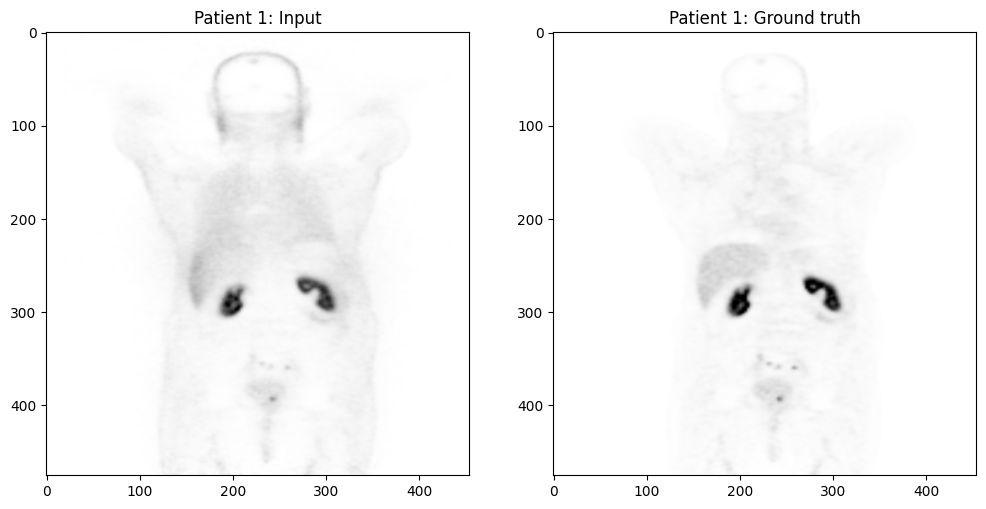

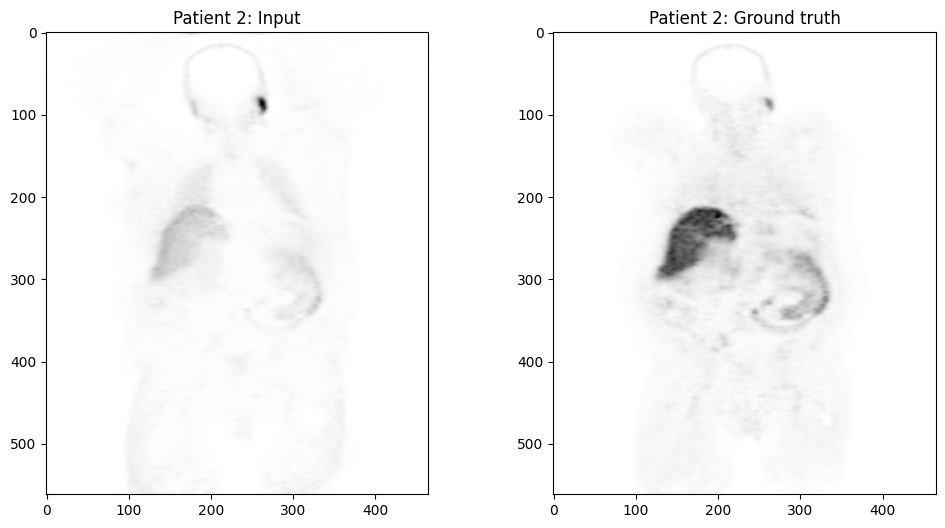

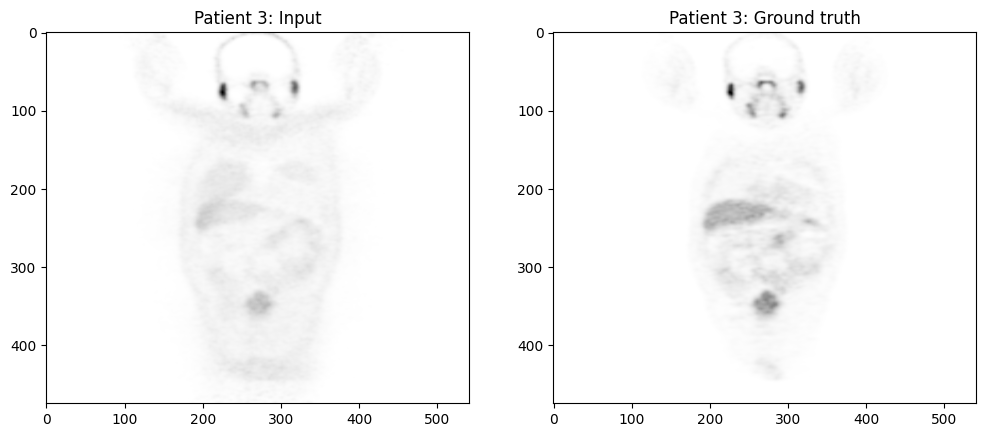

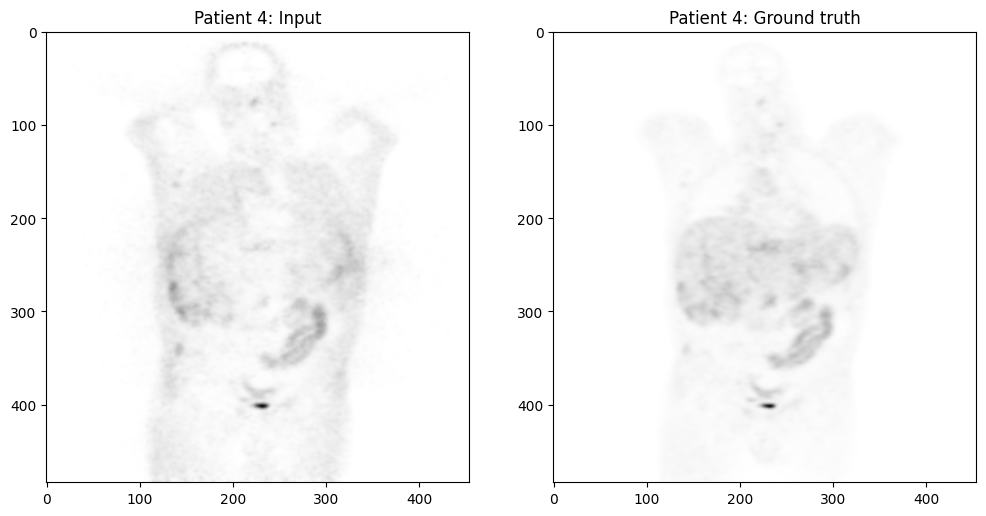

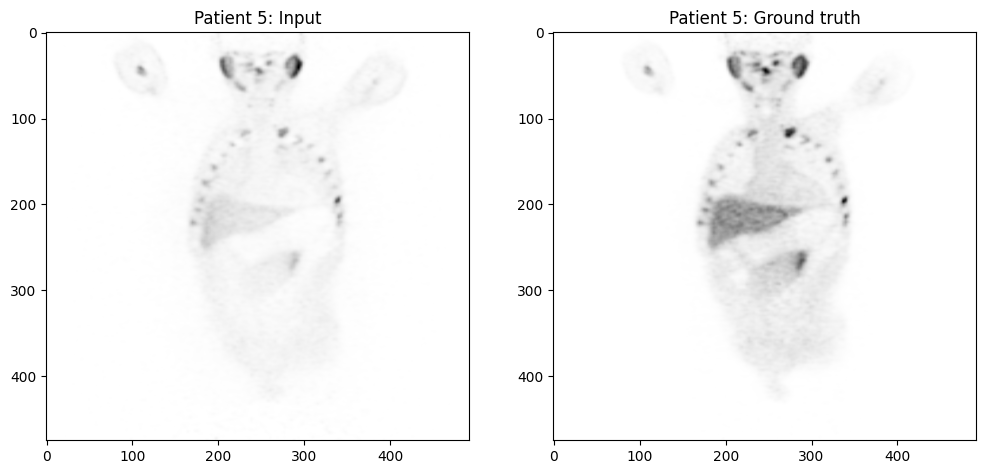

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from monai.data import DataLoader

# Assuming val_loader is already defined and loaded with your validation data
n = 220  # Selecting the slice

for i, data in enumerate(val_loader):
    image, target = (data["image"][0][0], data["target"][0][0])
    
    # Check if the selected slice index is within the bounds for the current image and target
    if n >= image.shape[1] or n >= target.shape[1]:  # Assuming the second dimension is the slice index
        print(f"Skipping patient {i+1}: slice index {n} is out of bounds for this patient.")
        continue

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Patient {i+1}: Input")
    input_slice = np.rot90(image[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 2, 2)
    plt.title(f"Patient {i+1}: Ground truth")
    target_slice = np.rot90(target[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(target_slice, cmap='gist_yarg')

    plt.show()


In [ ]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break

Batch 0 image size: torch.Size([1, 1, 180, 180, 312])


# **Create Model, Loss, Optimizer**

In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [ ]:
max_epochs = 10
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []

In [ ]:


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, targets = (batch_data["image"].to(device),
                           batch_data["target"].to(device),)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    train_losses.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (val_data["image"].to(device),
                                           val_data["target"].to(device),)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            val_losses.append(val_loss)
            print(f"Validation loss: {val_loss:.4f}")

            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_PET.pth"))
                print("Saved new best metric model")

print(f"Training completed. Best validation loss: {best_metric:.4f} at epoch {best_metric_epoch}")


----------
epoch 1/50
1/10, train_loss: 1.1080
2/10, train_loss: 0.9068
3/10, train_loss: 0.8664
4/10, train_loss: 0.6536
5/10, train_loss: 0.9391
6/10, train_loss: 0.5757
7/10, train_loss: 0.8121
8/10, train_loss: 0.9511
9/10, train_loss: 0.5575
10/10, train_loss: 0.5564
epoch 1 average loss: 0.7927
----------
epoch 2/50
1/10, train_loss: 0.6152
2/10, train_loss: 0.7156
3/10, train_loss: 1.1572
4/10, train_loss: 0.4927
5/10, train_loss: 0.6988
6/10, train_loss: 0.4017
7/10, train_loss: 0.5203
8/10, train_loss: 0.6247
9/10, train_loss: 0.6165
10/10, train_loss: 0.4641
epoch 2 average loss: 0.6307
Validation loss: 0.9327
Saved new best metric model
----------
epoch 3/50
1/10, train_loss: 0.6551
2/10, train_loss: 0.7947
3/10, train_loss: 0.5917
4/10, train_loss: 0.4239
5/10, train_loss: 0.6320
6/10, train_loss: 0.6780
7/10, train_loss: 0.3933
8/10, train_loss: 0.5415
9/10, train_loss: 0.5223
10/10, train_loss: 0.4601
epoch 3 average loss: 0.5693
----------
epoch 4/50
1/10, train_loss: 0.

In [ ]:
import numpy as np
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure(figsize=(14, 6))  # Set the size of the figure

# Plotting the training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha = 0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))

plt.show()

100%|██████████| 7/7 [01:56<00:00, 16.66s/it]


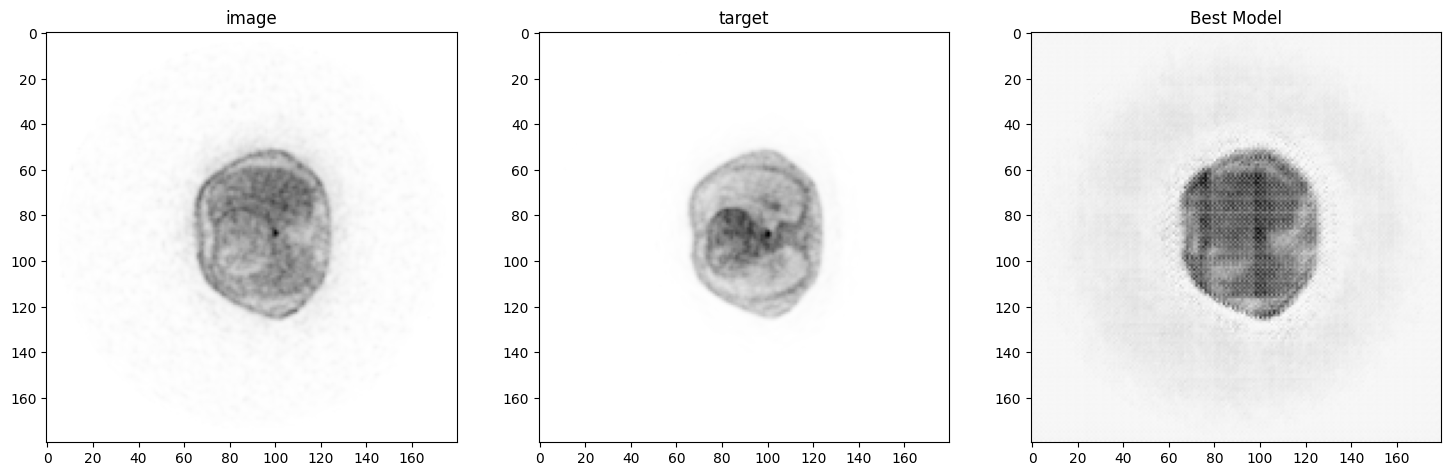

In [ ]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


    # Load the best model state for visualization
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_PET.pth")))
model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 200
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break




In [ ]:
#         if dice_after > best_eval_dice:
#             best_eval_dice = dice_after
#             if do_save:
#                 # Save best model based on Dice
#                 if pth_best_dice != "":
#                     os.remove(os.path.join(dir_save, pth_best_dice))
#                 pth_best_dice = f"segresnet_kpt_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
#                 torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
#                 print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

#     if do_save:
#         # Save latest model
#         if pth_latest != "":
#             os.remove(os.path.join(dir_save, pth_latest))
#         pth_latest = "segresnet_kpt_loss_latest.pth"
#         torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


# # learn2reg_nlst_paired_lung_CT notbook